___
## Manipulación de Datos Espaciales

En el taller anterior vimos una introducción a algunos de los conceptos básicos del trabajo con datos geográficos usando GeoPandas. Ahora vamos a usar la librería para realizar algunas manipulaciones más avanzadas.


Como siempre, primero importamos las librerías.

In [10]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### Datos del Censo

En este taller vamos a trabajar una vez más con los datos del Censo de Población y Vivienda del INEGI. Lo primero que vamos a hacer es leer los datos y volverlos a procesar para obtener los totales por AGEB.

In [4]:
db = pd.read_csv('datos/conjunto_de_datos_ageb_urbana_09_cpv2020.zip',
                 dtype={'ENTIDAD': object,
                        'MUN':object,
                        'LOC':object,
                        'AGEB':object})
db = db.loc[db['NOM_LOC'] == 'Total AGEB urbana']
db = (db  
      .replace('999999999', np.nan)
      .replace('99999999', np.nan)
      .replace('*', np.nan)
      .replace('N/D', np.nan))
diccionario = pd.read_csv('datos/diccionario_datos_ageb_urbana_09_cpv2020.csv', skiprows=3)
campos_datos = diccionario.loc[8:,]['Mnemónico']
db[campos_datos] = db[campos_datos].astype('float')
db['AGEB_cvgeo'] = db['ENTIDAD'] + db['MUN'] + db['LOC'] + db['AGEB']
db.head()

/tmp/ipykernel_4795/1463692114.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  db['AGEB_cvgeo'] = db['ENTIDAD'] + db['MUN'] + db['LOC'] + db['AGEB']


ENTIDAD           NOM_ENT  MUN       NOM_MUN   LOC            NOM_LOC  \
3        09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
30       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
82       09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
116      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   
163      09  Ciudad de México  002  Azcapotzalco  0001  Total AGEB urbana   

     AGEB  MZA  POBTOT  POBFEM  ...  VPH_CEL  VPH_INTER  VPH_STVP  VPH_SPMVPI  \
3    0010    0  3183.0  1695.0  ...    772.0      692.0     313.0       221.0   
30   0025    0  5593.0  2915.0  ...   1510.0     1203.0     478.0       349.0   
82   003A    0  4235.0  2232.0  ...   1049.0      878.0     361.0       339.0   
116  0044    0  4768.0  2551.0  ...   1237.0     1076.0     481.0       452.0   
163  0097    0  2176.0  1115.0  ...    562.0      507.0     276.0       260.0   

     VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC     AGEB_cvgeo  
3      145.0         8.0        14.0        148.0         5.0  0900200010010  
30     238.0        28.0        68.0        393.0        14.0  0900200010025  
82     247.0         5.0        12.0        250.0         NaN  090020001003A  
116    294.0        10.0        17.0        254.0         NaN  0900200010044  
163    153.0         4.0         3.0         70.0         0.0  0900200010097  

[5 rows x 231 columns]

### Unión de Tablas

En la práctica anterior usamos las geopmetrías de la AGEBS. Ahora podemos unir ambas tablas para tener una base de datos completa a partir de la cual hacer análisis espacial.

Leamos entonces los datos de las geometrías.

In [5]:
agebs = gpd.read_file("datos/agebs_cdmx.zip")  # Importar los datos espaciales
agebs

CVEGEO CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  \
0     0901000011716      09     010    0001     1716   
1     0901000012150      09     010    0001     2150   
2     0901000011133      09     010    0001     1133   
3     0901000011307      09     010    0001     1307   
4     0901000010281      09     010    0001     0281   
...             ...     ...     ...     ...      ...   
2426  0900700012564      09     007    0001     2564   
2427  0900700012615      09     007    0001     2615   
2428  0900700012969      09     007    0001     2969   
2429  0900700013721      09     007    0001     3721   
2430  0900700011034      09     007    0001     1034   

                                               geometry  
0     POLYGON ((2787237.541 816989.461, 2787288.728 ...  
1     POLYGON ((2794154.458 823013.444, 2794155.774 ...  
2     POLYGON ((2795690.723 820050.788, 2795684.238 ...  
3     POLYGON ((2792584.475 815678.668, 2792624.325 ...  
4     POLYGON ((2788845.392 823526.074, 2788840.549 ...  
...                                                 ...  
2426  POLYGON ((2814016.268 821043.511, 2814019.319 ...  
2427  POLYGON ((2814358.791 820744.850, 2814405.087 ...  
2428  POLYGON ((2815993.470 819777.763, 2816019.848 ...  
2429  POLYGON ((2807966.150 821578.350, 2807941.550 ...  
2430  POLYGON ((2808319.196 821552.683, 2808243.251 ...  

[2431 rows x 6 columns]

El campo a través del cual se deben unir es `CVEGEO` en las geometrías y `AGEB_cvgeo` en los tabulados. Como ya hemos visto hay diferentes formas de lograr esto, en este caso vamos a usar [`join()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) que nos permite unir a través de una columna o índice en la bese _izquierda_ (la que llama a la función) y el índice en la base derecha. Observen entonces lo que sicede si unimos a través de los índices:

In [8]:
agebs.set_index('CVEGEO').join(db.set_index('AGEB_cvgeo'), how='inner')

CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  \
0901000011716      09     010    0001     1716   
0901000012150      09     010    0001     2150   
0901000011133      09     010    0001     1133   
0901000011307      09     010    0001     1307   
0901000010281      09     010    0001     0281   
...               ...     ...     ...      ...   
0900700012564      09     007    0001     2564   
0900700012615      09     007    0001     2615   
0900700012969      09     007    0001     2969   
0900700013721      09     007    0001     3721   
0900700011034      09     007    0001     1034   

                                                        geometry ENTIDAD  \
0901000011716  POLYGON ((2787237.541 816989.461, 2787288.728 ...      09   
0901000012150  POLYGON ((2794154.458 823013.444, 2794155.774 ...      09   
0901000011133  POLYGON ((2795690.723 820050.788, 2795684.238 ...      09   
0901000011307  POLYGON ((2792584.475 815678.668, 2792624.325 ...      09   
0901000010281  POLYGON ((2788845.392 823526.074, 2788840.549 ...      09   
...                                                          ...     ...   
0900700012564  POLYGON ((2814016.268 821043.511, 2814019.319 ...      09   
0900700012615  POLYGON ((2814358.791 820744.850, 2814405.087 ...      09   
0900700012969  POLYGON ((2815993.470 819777.763, 2816019.848 ...      09   
0900700013721  POLYGON ((2807966.150 821578.350, 2807941.550 ...      09   
0900700011034  POLYGON ((2808319.196 821552.683, 2808243.251 ...      09   

                        NOM_ENT  MUN         NOM_MUN   LOC  ... VPH_TELEF  \
0901000011716  Ciudad de México  010  Álvaro Obregón  0001  ...    1119.0   
0901000012150  Ciudad de México  010  Álvaro Obregón  0001  ...    1162.0   
0901000011133  Ciudad de México  010  Álvaro Obregón  0001  ...     689.0   
0901000011307  Ciudad de México  010  Álvaro Obregón  0001  ...     783.0   
0901000010281  Ciudad de México  010  Álvaro Obregón  0001  ...      64.0   
...                         ...  ...             ...   ...  ...       ...   
0900700012564  Ciudad de México  007      Iztapalapa  0001  ...    1064.0   
0900700012615  Ciudad de México  007      Iztapalapa  0001  ...    1181.0   
0900700012969  Ciudad de México  007      Iztapalapa  0001  ...     400.0   
0900700013721  Ciudad de México  007      Iztapalapa  0001  ...     975.0   
0900700011034  Ciudad de México  007      Iztapalapa  0001  ...    1450.0   

              VPH_CEL  VPH_INTER  VPH_STVP  VPH_SPMVPI  VPH_CVJ  VPH_SINRTV  \
0901000011716  1660.0     1181.0     644.0       279.0    210.0        45.0   
0901000012150  1497.0     1290.0     993.0       695.0    450.0        21.0   
0901000011133   746.0      733.0     568.0       545.0    212.0        19.0   
0901000011307   839.0      831.0     768.0       640.0    348.0         NaN   
0901000010281    68.0       64.0      60.0        48.0     30.0         0.0   
...               ...        ...       ...         ...      ...         ...   
0900700012564  1512.0     1103.0     331.0       248.0    154.0        48.0   
0900700012615  1785.0     1206.0     406.0       288.0    204.0        64.0   
0900700012969   543.0      394.0      93.0        66.0     54.0        18.0   
0900700013721  1157.0     1049.0     606.0       342.0    192.0        10.0   
0900700011034  1669.0     1443.0     920.0       562.0    366.0        17.0   

               VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  
0901000011716        82.0        601.0         9.0  
0901000012150        24.0        261.0         NaN  
0901000011133         NaN         23.0         0.0  
0901000011307         0.0         18.0         0.0  
0901000010281         0.0          0.0         0.0  
...                   ...          ...         ...  
0900700012564       120.0        645.0        18.0  
0900700012615       101.0        712.0        11.0  
0900700012969        36.0        246.0         4.0  
0900700013721        32.0        197.0         4.0  
0900700011034        45.0        350.0     

Para poder usar `join()` fijamos los índices en las dos bases usando [`set_index()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html). De esta forma la unión se hace sobre las filas en las que los valores de ambas columnas coincidan. La condicion `how='inner'` especifica el tipo de unión que queremos, en este caso la unión interior.

Ya que entendimos la lógica, guardemos el resultado de la unión en la variable en donde tenemos las geometrías:

In [9]:
agebs = agebs.set_index('CVEGEO').join(db.set_index('AGEB_cvgeo'), how='inner')
agebs.head()

CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  \
0901000011716      09     010    0001     1716   
0901000012150      09     010    0001     2150   
0901000011133      09     010    0001     1133   
0901000011307      09     010    0001     1307   
0901000010281      09     010    0001     0281   

                                                        geometry ENTIDAD  \
0901000011716  POLYGON ((2787237.541 816989.461, 2787288.728 ...      09   
0901000012150  POLYGON ((2794154.458 823013.444, 2794155.774 ...      09   
0901000011133  POLYGON ((2795690.723 820050.788, 2795684.238 ...      09   
0901000011307  POLYGON ((2792584.475 815678.668, 2792624.325 ...      09   
0901000010281  POLYGON ((2788845.392 823526.074, 2788840.549 ...      09   

                        NOM_ENT  MUN         NOM_MUN   LOC  ... VPH_TELEF  \
0901000011716  Ciudad de México  010  Álvaro Obregón  0001  ...    1119.0   
0901000012150  Ciudad de México  010  Álvaro Obregón  0001  ...    1162.0   
0901000011133  Ciudad de México  010  Álvaro Obregón  0001  ...     689.0   
0901000011307  Ciudad de México  010  Álvaro Obregón  0001  ...     783.0   
0901000010281  Ciudad de México  010  Álvaro Obregón  0001  ...      64.0   

              VPH_CEL  VPH_INTER  VPH_STVP  VPH_SPMVPI  VPH_CVJ  VPH_SINRTV  \
0901000011716  1660.0     1181.0     644.0       279.0    210.0        45.0   
0901000012150  1497.0     1290.0     993.0       695.0    450.0        21.0   
0901000011133   746.0      733.0     568.0       545.0    212.0        19.0   
0901000011307   839.0      831.0     768.0       640.0    348.0         NaN   
0901000010281    68.0       64.0      60.0        48.0     30.0         0.0   

               VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  
0901000011716        82.0        601.0         9.0  
0901000012150        24.0        261.0         NaN  
0901000011133         NaN         23.0         0.0  
0901000011307         0.0         18.0         0.0  
0901000010281         0.0          0.0         0.0  

[5 rows x 235 columns]

Ahora que tenemos ya los tabulados y las geometrías en un mismo GeoDataFrame, podemos fácilmente hacer cálculos y mapas a partir de los datos. Por ejemplo, veamos dónde quedan las 10 Agebs con mayor población.

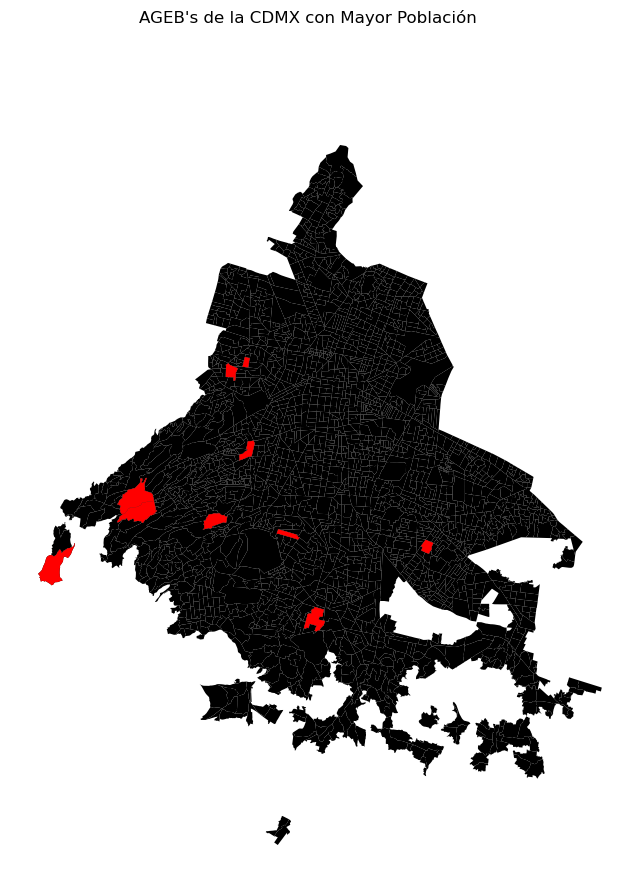

In [11]:
agebs_mas_pobladas = agebs.sort_values('POBTOT', ascending = False).head(10)
fig, ax = plt.subplots(1, figsize=(10, 10))
agebs.plot(facecolor='black', linewidth=0.025, ax=ax)              # Capa Base de AGEB's
agebs_mas_pobladas.plot(alpha=1, facecolor='red', linewidth=0, ax=ax) # Capa AGEB's más pobladas
ax.set_axis_off()
fig.suptitle("AGEB's de la CDMX con Mayor Población")
plt.show()

### Manipulaciones Espaciales
Además de las operaciones basadas únicamente en valores, como las realizadas anteriormente, es posible realizar sobre un `GeoDataFrame` una gran variedad de operaciones encontradas en los SIG. A continuación se detallarán algunas de las más comunes

#### Cálculo de Centroides
En algunos casos, resulta útil simplificar un polígono en un sólo punto y, para ello, se calculan los Centroides (siendo algo como el análogo espacial de la media estadística). El siguiente comando dará como resultado un objeto del tipo `GeoSeries` (una sola columna con datos espaciales) con los Centroides de los polígonos contenidos en un `GeoDataFrame`:

In [12]:
centroides = agebs.centroid
centroides.head()

0901000011716    POINT (2787091.708 816590.463)
0901000012150    POINT (2793986.972 823047.548)
0901000011133    POINT (2794967.016 819439.549)
0901000011307    POINT (2792230.506 815397.361)
0901000010281    POINT (2788669.707 823554.634)
dtype: geometry

Los `centroides` son un objeto del tipo [`GeoSeries`](https://geopandas.org/en/stable/docs/reference/geoseries.html), el equivalente en Geopandas a una Serie de Pandas.

<AxesSubplot: >

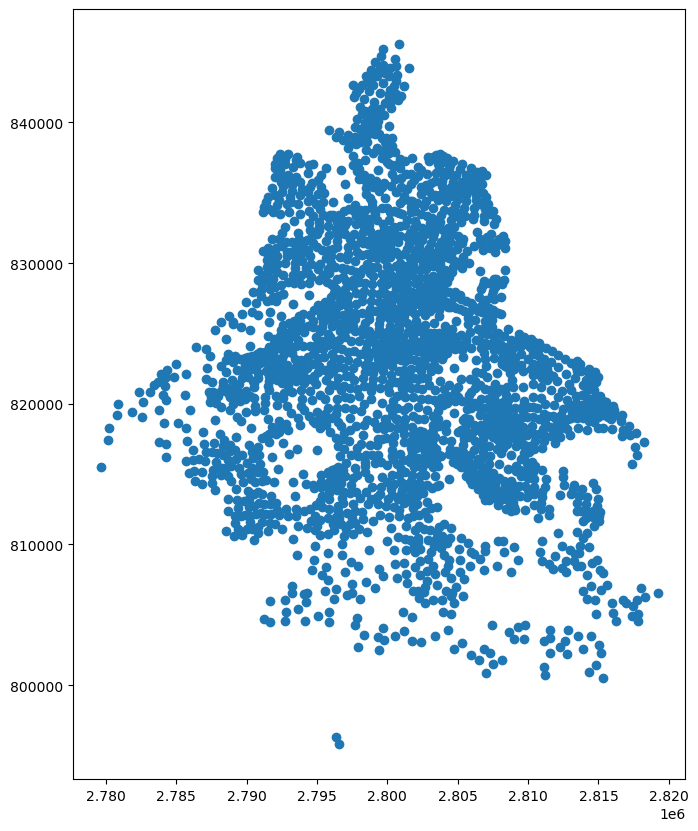

In [13]:
centroides.plot(figsize = (10,10))


### Punto en Polígono (Point-In-Polygon)

Una operación común es preguntar si un punto determinado cae dentro o no de un polígono. Para este tipo de operaciones GeoPandas provee un conjunto de [_predicados espaciales_](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates). El que nos permite responder a la pregunta que planteamos es `contains()` que regresa _cierto_ siempre que la geometría que llama contenga a la geometría con que se compara:

In [14]:
poligono = agebs['geometry'][0]  # Se aisla el primer polígono dela tabla
punto1 = centroides[0]              # Se aisla el primer punto de la serie
punto2 = centroides[1]              # Se aisla el segundo punto de la serie

In [15]:
poligono.contains(punto1)

True

In [16]:
poligono.contains(punto2)

False

El método anterior permite realizar una verificación rápida y cualitativa de si un punto se encuentra dentro de un polígono; sin embargo, en muchos otros casos esto no resulta ser muy eficiente, por lo que se recurre a una operación conocida como *Spatial Join*; éstos serán estudiados más a fondo en futuras prácticas.

### Buffers
Los Buffers son parte de las operaciones clásicas de un SIG, y consisten en trazar un área alrededor de una geometría en particular, dado un radio específico. Éstos resultan bastate útiles al momento de combinarlos, por ejemplo, con operaciones de *Point-In-Polygon* para calcular valores de accesibilidad, áreas de influencia, entre otros.

Para crear un Buffer a través de `GeoPandas`, puede utilizarse el método [`buffer()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html), al cual se le coloca como argumento el radio deseado. Es importante tomar en cuenta que el radio especificado necesita encontrarse en las mismas unidades que el Sistema de Coordenadas de Referencia (CRS) de la geometría con la que se esté trabajando. Por ejemplo, revisando la capa importada anteriormente de Estaciones del Metro:

In [18]:
estaciones = gpd.read_file("datos/estaciones_metro.zip")
estaciones.crs

<Derived Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

La propiedad `crs` indica que se trata de la proyección con Código EPSG 32614, de la cual, [al investigar sobre ella](http://epsg.io/32614), se tiene que se trata de una proyección que trabaja en metros. Como tal, si se buscara generar un Buffer de 500m alrededor de cada estación, simplemente se tendría que:

In [19]:
buff = estaciones.buffer(500)
buff.head()

0    POLYGON ((485905.843 2149860.572, 485903.435 2...
1    POLYGON ((486208.110 2152724.378, 486205.702 2...
2    POLYGON ((480784.558 2142470.874, 480782.151 2...
3    POLYGON ((487661.939 2146081.726, 487659.532 2...
4    POLYGON ((480876.875 2142406.938, 480874.468 2...
dtype: geometry

Para representar éstos en un mapa, se recurre a los métodos estudiados anteriormente:

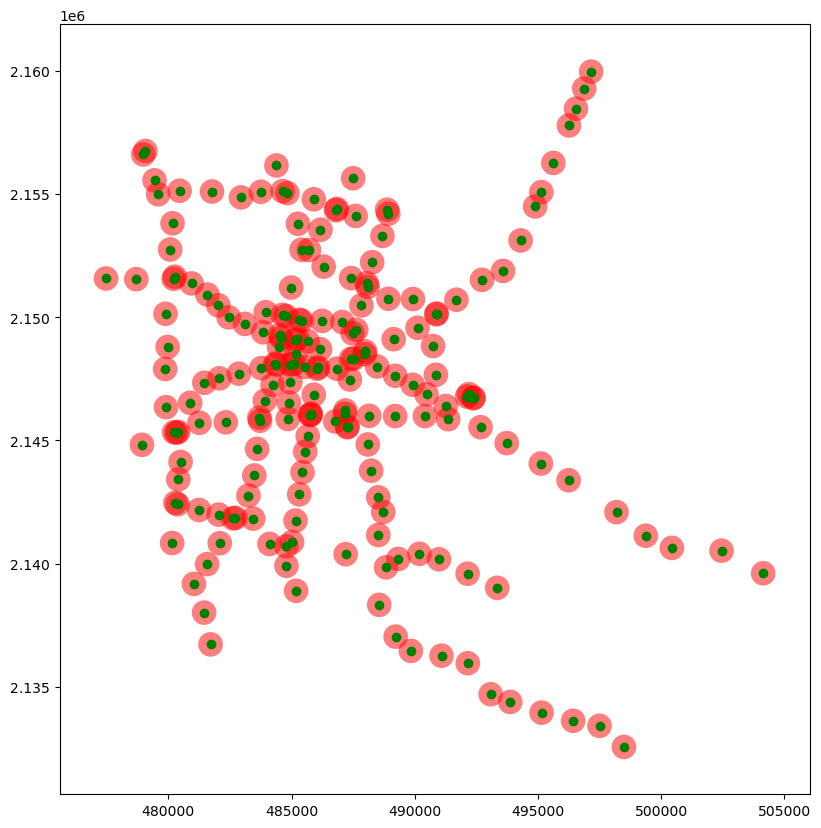

In [20]:
fig, fila = plt.subplots(1, figsize=(10, 10))

# Graficar los Buffers
buff.plot(ax = fila , alpha = 0.5 , facecolor = 'red', linewidth = 0)

# Graficar las Estaciones de Metro sobre las referencias
estaciones.plot(ax = fila , color = 'green')
plt.show()

#### Ejercicio Opcional
Genera un mapa de la Ciudad de México donde los polígonos de las AGEB's sean de color negro, y sobre ellos y de color amarillo los Buffers a 250m de cada uno de sus centroides.

### Coropletas

Para terminar la práctica de geovisualización vamos a hacer mapas de coropletas usando dos métodos diferentes. Primero vamos a usar directamente GeoPandas para generar los mapas y después vamos a usar [ipyLeaflet](https://ipyleaflet.readthedocs.io/en/latest/) para hacer una visualización interactiva.

Primero, recordemos que, dado que ya tenemos los datos de población unidos a las geometrías de las AGEBS, hacer un primer mapa usando GeoPandas, es tan sencillo como pasarle el nombre de la columna que queremos usar para colorear el mapa

<AxesSubplot: >

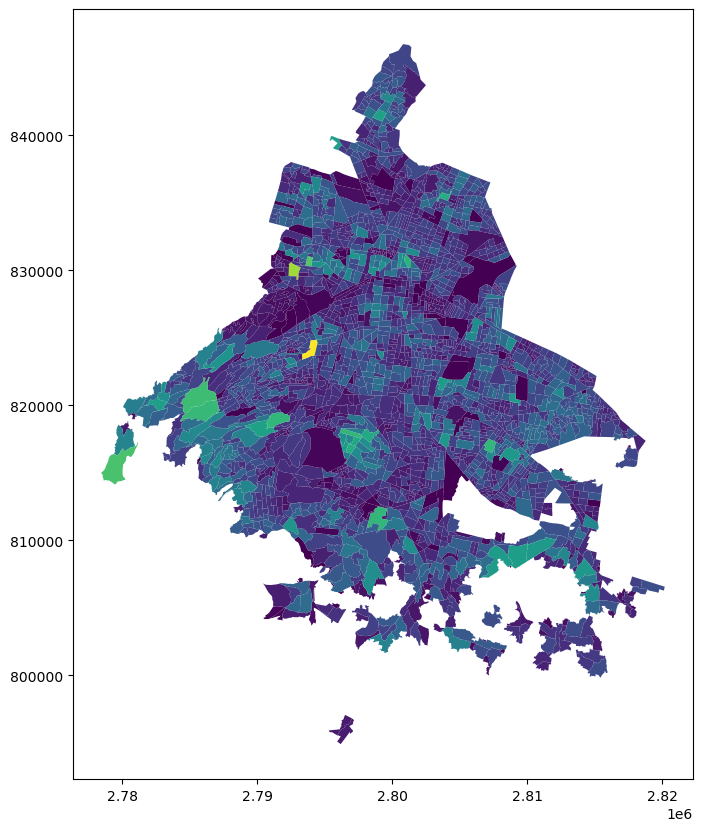

In [21]:
agebs.plot('POBTOT', figsize=(10,10))

Incluir una leyenda también es muy sencillo

<AxesSubplot: >

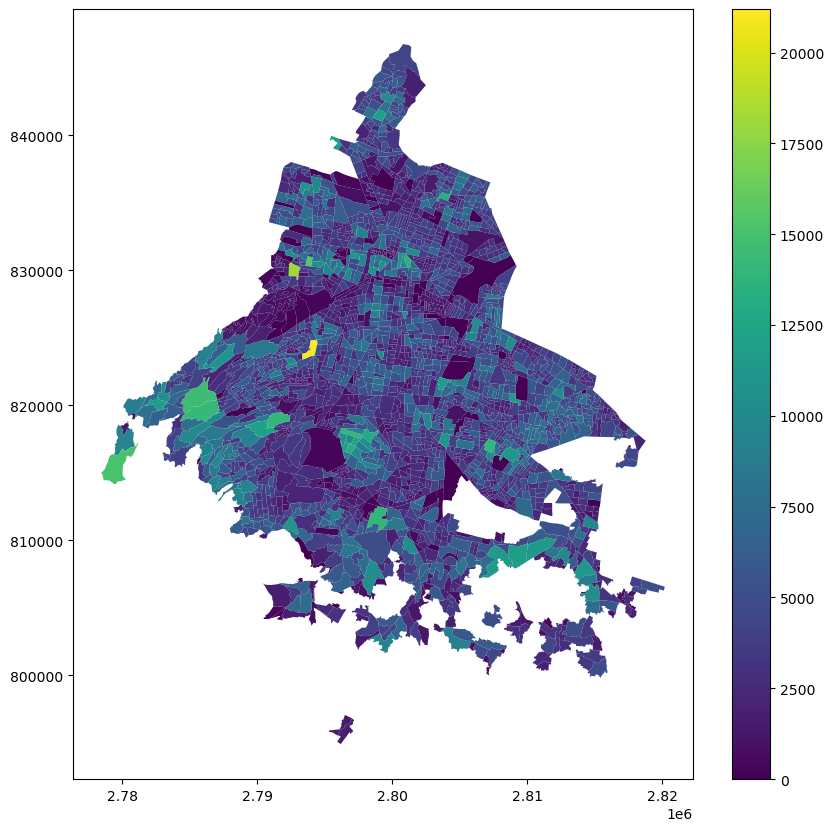

In [22]:
agebs.plot('POBTOT', figsize=(10,10), legend=True)

Y cambiar la paleta de colores

<AxesSubplot: >

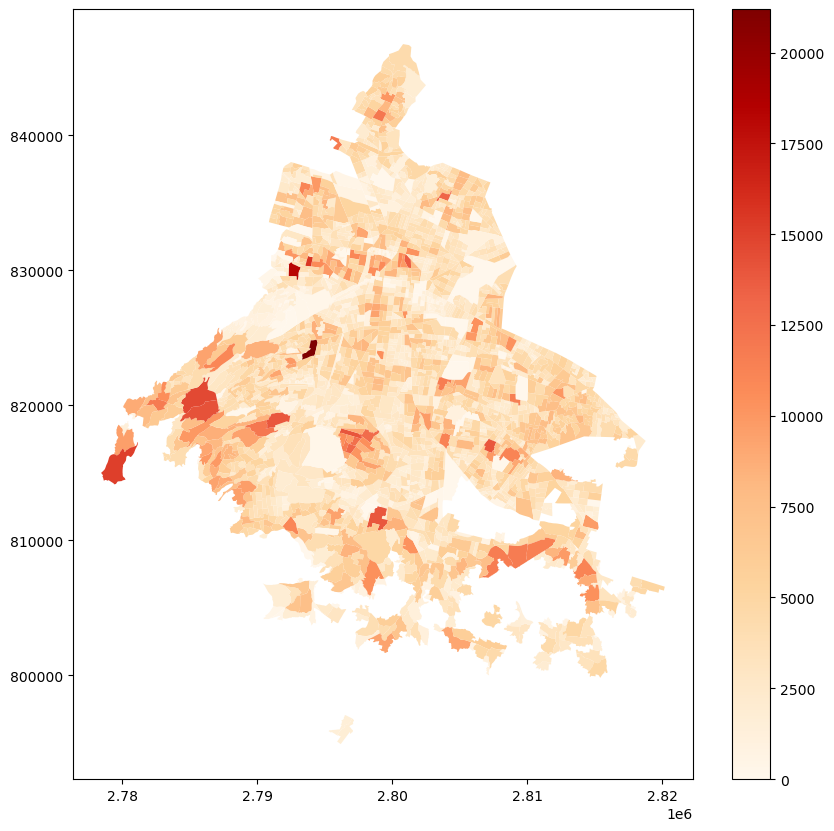

In [23]:
agebs.plot('POBTOT', figsize=(10,10), legend=True, cmap='OrRd')

En la documentación de [GeoDtaFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) pueden ver la lista completa de opciones.

En estos primeros mapas que hemos hecho usamos una escala continua para representar la variable de interés. Otra forma de representar la variación espacial es utilizando un esquema de clasificación discreto sobre nuestra variable de interés, por ejemplo cuantiles, intervalos iguales, etcétera. Para esto, `GeoDtaFrame.plot()` admite pasarle el parámetro `scheme` que toma cualquier esquema de clasificación admitido por [mapclassify](https://github.com/pysal/mapclassify).

<AxesSubplot: >

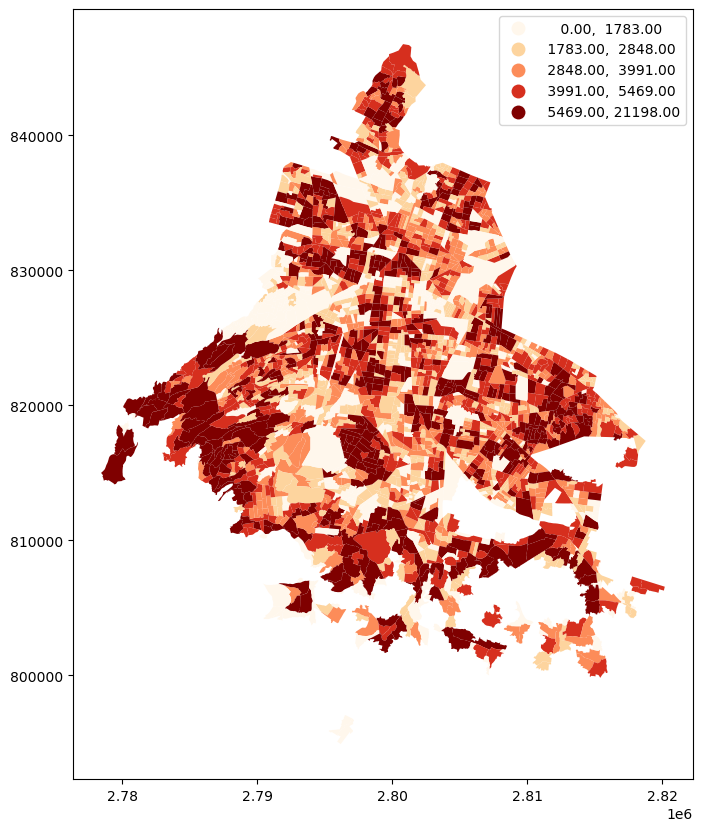

In [24]:
agebs.plot('POBTOT', figsize=(10,10), legend=True, cmap='OrRd', scheme='quantiles')

#### Ejercicio

Prueben diferentes esquemas de clasificación ([aquí](https://geopandas.org/en/stable/docs/user_guide/mapping.html) pueden encontrar la lista de esquemas disponibles) y discutan sobre qué esquema representa mejor la variación espacial de los datos 

### Mejorando el estilo

Los mapas que hemos hecho son relativamente sencillos, para darles una mejor presentación podemos tomar algunas cosas que ya hemos aprendido, por ejemplo eliminar los ejes y ponerles un título:

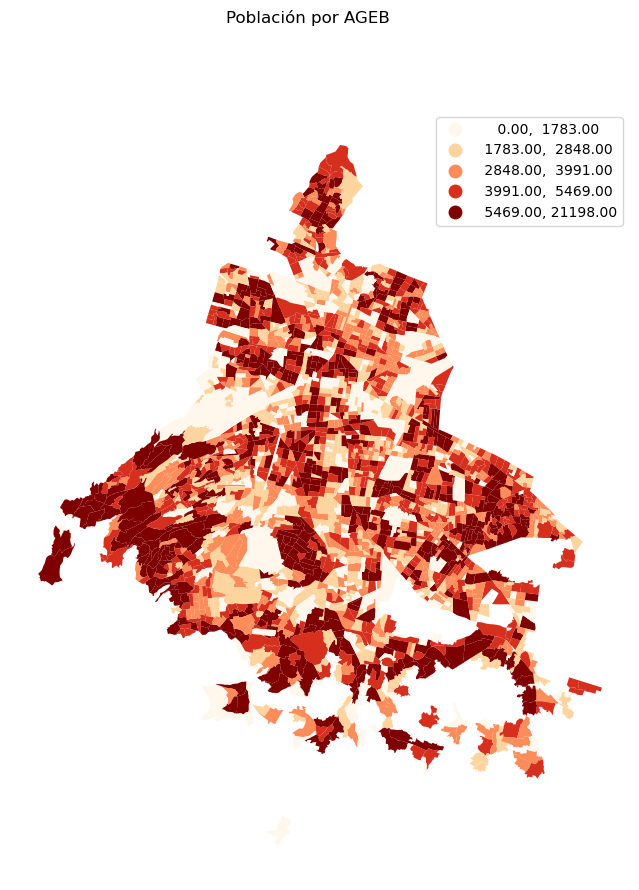

In [25]:
fig , fila = plt.subplots(1, figsize=(10,10))
agebs.plot('POBTOT', figsize=(10,10), legend=True, cmap='OrRd', scheme='quantiles', ax=fila)
fig.suptitle("Población por AGEB")
fila.set_axis_off()  
plt.show()

También es posible agregar un mapa base utilizando la librería [contextily](https://contextily.readthedocs.io/en/latest/)

In [27]:
import contextily as ctx

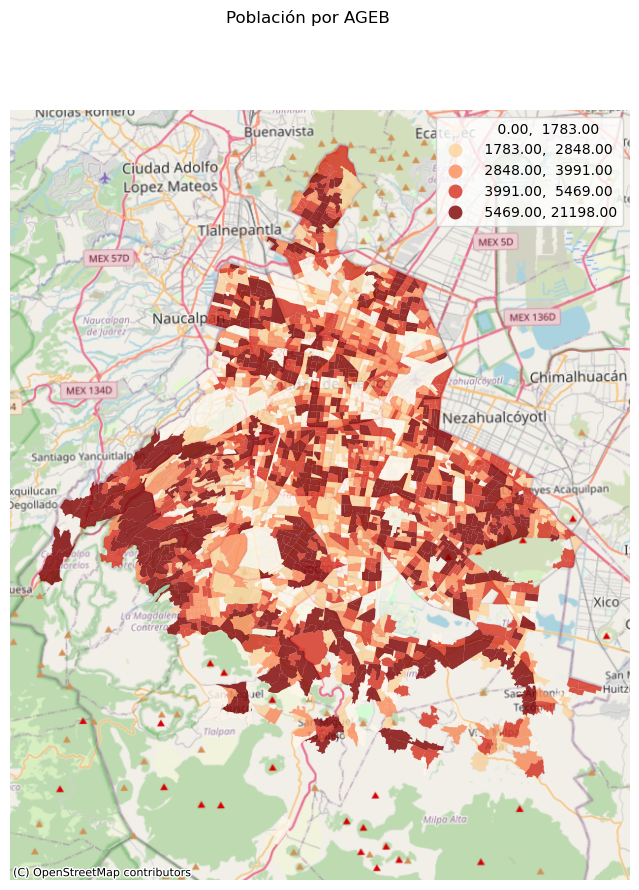

In [29]:
fig , fila = plt.subplots(1, figsize=(10,10))
agebs.plot('POBTOT', figsize=(10,10), legend=True, cmap='OrRd', scheme='quantiles', ax=fila, alpha=0.8)
fig.suptitle("Población por AGEB")
fila.set_axis_off()
ctx.add_basemap(fila, source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
plt.show()

#### Ejercicio

Prueben usando diferentes mapas base, y cambiando el fondo de la imágen.

### Varios mapas en la misma figura

A veces queremos hacer una imagen que nos permita comparar rápidamente una variable, para eso es conveniente poner juntos dos mapas. Pensemos en este momento en comparar la población por AGEB con la densidad de población por AGEB. Obviamente el pri er paso es calcular la densidad de población, para esto vamos a usar la propiedad `área` de los GeoDataFrames. Fíjense como reproyectamos antes de calcular el area para obtener un valor en metros cuadrados

In [30]:
agebs.to_crs(32614).area

0901000011716    2.667296e+05
0901000012150    2.205941e+05
0901000011133    5.884493e+05
0901000011307    1.064274e+06
0901000010281    1.915020e+05
                     ...     
0900700012564    3.412877e+05
0900700012615    2.797808e+05
0900700012969    1.567320e+05
0900700013721    2.219631e+05
0900700011034    3.472613e+05
Length: 2431, dtype: float64

In [31]:
agebs['densidad_pob'] = agebs['POBTOT'] / agebs.to_crs(32614).area
agebs.head()

CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  \
0901000011716      09     010    0001     1716   
0901000012150      09     010    0001     2150   
0901000011133      09     010    0001     1133   
0901000011307      09     010    0001     1307   
0901000010281      09     010    0001     0281   

                                                        geometry ENTIDAD  \
0901000011716  POLYGON ((2787237.541 816989.461, 2787288.728 ...      09   
0901000012150  POLYGON ((2794154.458 823013.444, 2794155.774 ...      09   
0901000011133  POLYGON ((2795690.723 820050.788, 2795684.238 ...      09   
0901000011307  POLYGON ((2792584.475 815678.668, 2792624.325 ...      09   
0901000010281  POLYGON ((2788845.392 823526.074, 2788840.549 ...      09   

                        NOM_ENT  MUN         NOM_MUN   LOC  ... VPH_CEL  \
0901000011716  Ciudad de México  010  Álvaro Obregón  0001  ...  1660.0   
0901000012150  Ciudad de México  010  Álvaro Obregón  0001  ...  1497.0   
0901000011133  Ciudad de México  010  Álvaro Obregón  0001  ...   746.0   
0901000011307  Ciudad de México  010  Álvaro Obregón  0001  ...   839.0   
0901000010281  Ciudad de México  010  Álvaro Obregón  0001  ...    68.0   

              VPH_INTER  VPH_STVP  VPH_SPMVPI  VPH_CVJ  VPH_SINRTV  \
0901000011716    1181.0     644.0       279.0    210.0        45.0   
0901000012150    1290.0     993.0       695.0    450.0        21.0   
0901000011133     733.0     568.0       545.0    212.0        19.0   
0901000011307     831.0     768.0       640.0    348.0         NaN   
0901000010281      64.0      60.0        48.0     30.0         0.0   

               VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  densidad_pob  
0901000011716        82.0        601.0         9.0      0.026401  
0901000012150        24.0        261.0         NaN      0.020798  
0901000011133         NaN         23.0         0.0      0.003744  
0901000011307         0.0         18.0         0.0      0.002738  
0901000010281         0.0          0.0         0.0      0.001238  

[5 rows x 236 columns]

Ahora sí podemos hacer una figura que incluya dos mapas. Hasta ahora siempre hemos usado `fig , ax = plt.subplots(1, figsize=(10,10))` para hacer un subplot con una sóla gráfica, lo que vamos a hacer es usarlo ahora para obtener dos ejes en los que graficar.

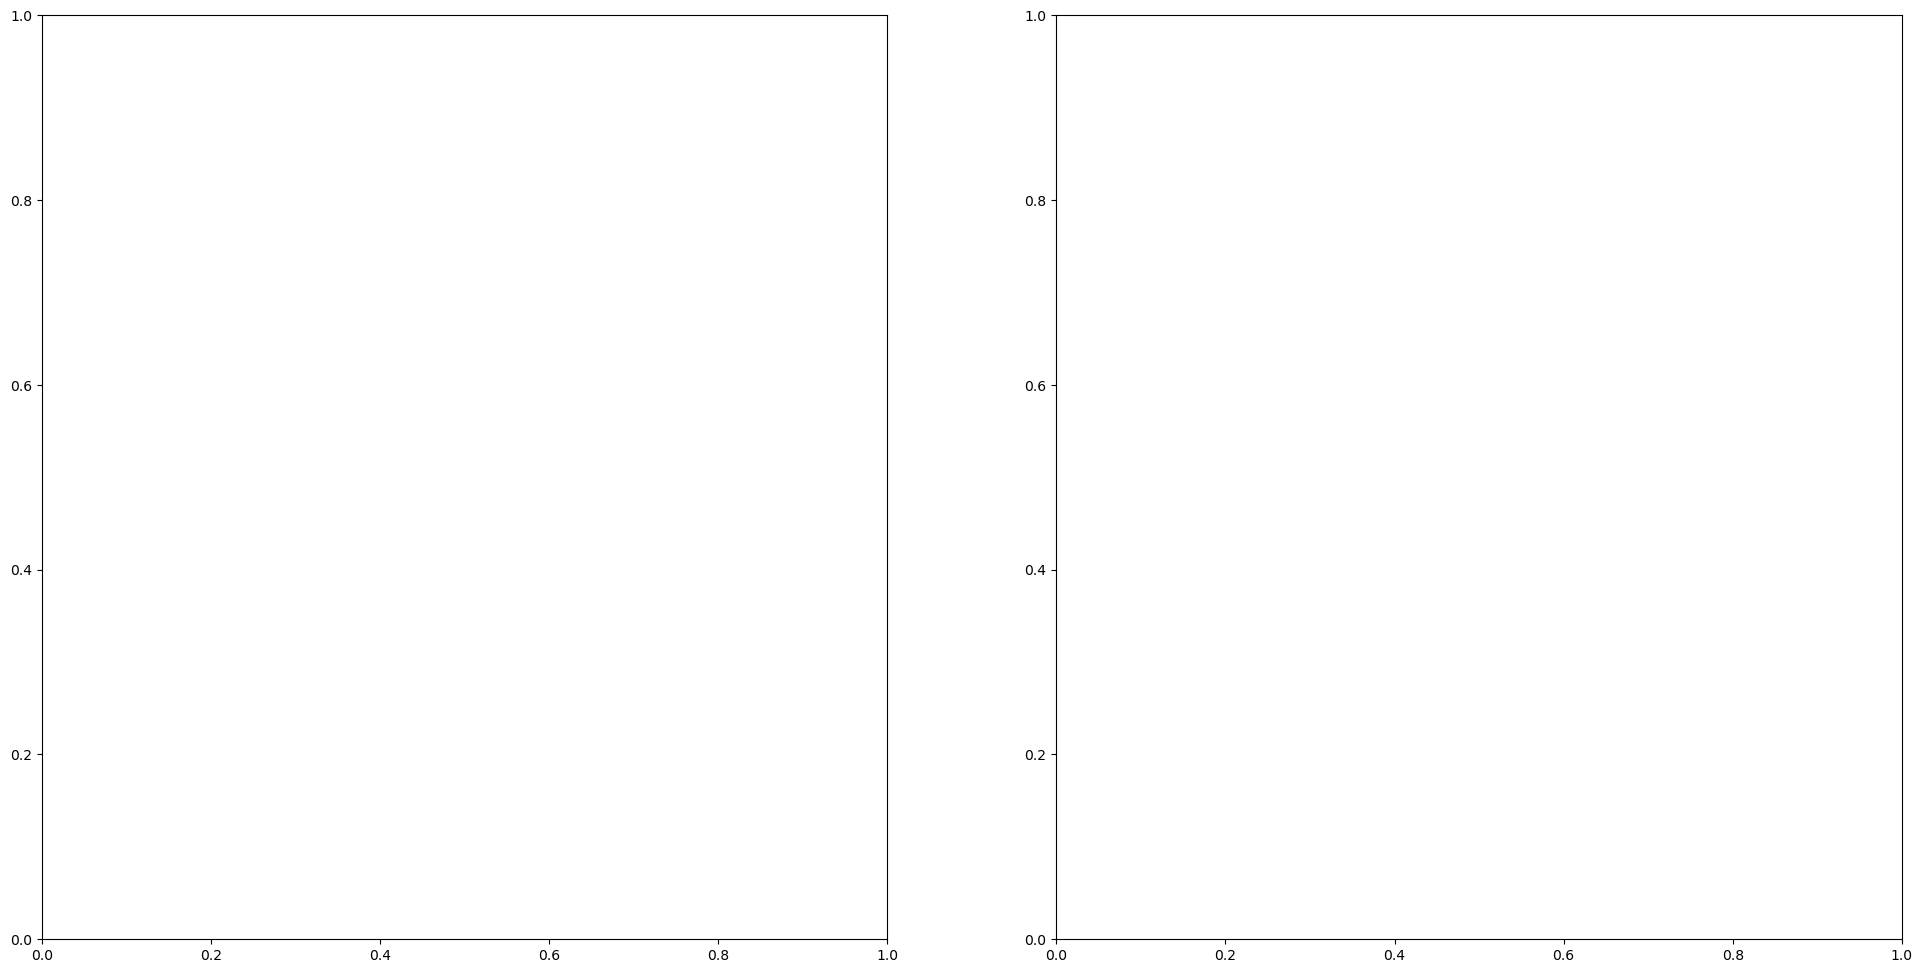

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,12)) # Pedimos subfiguras con un renglón y dos columnas

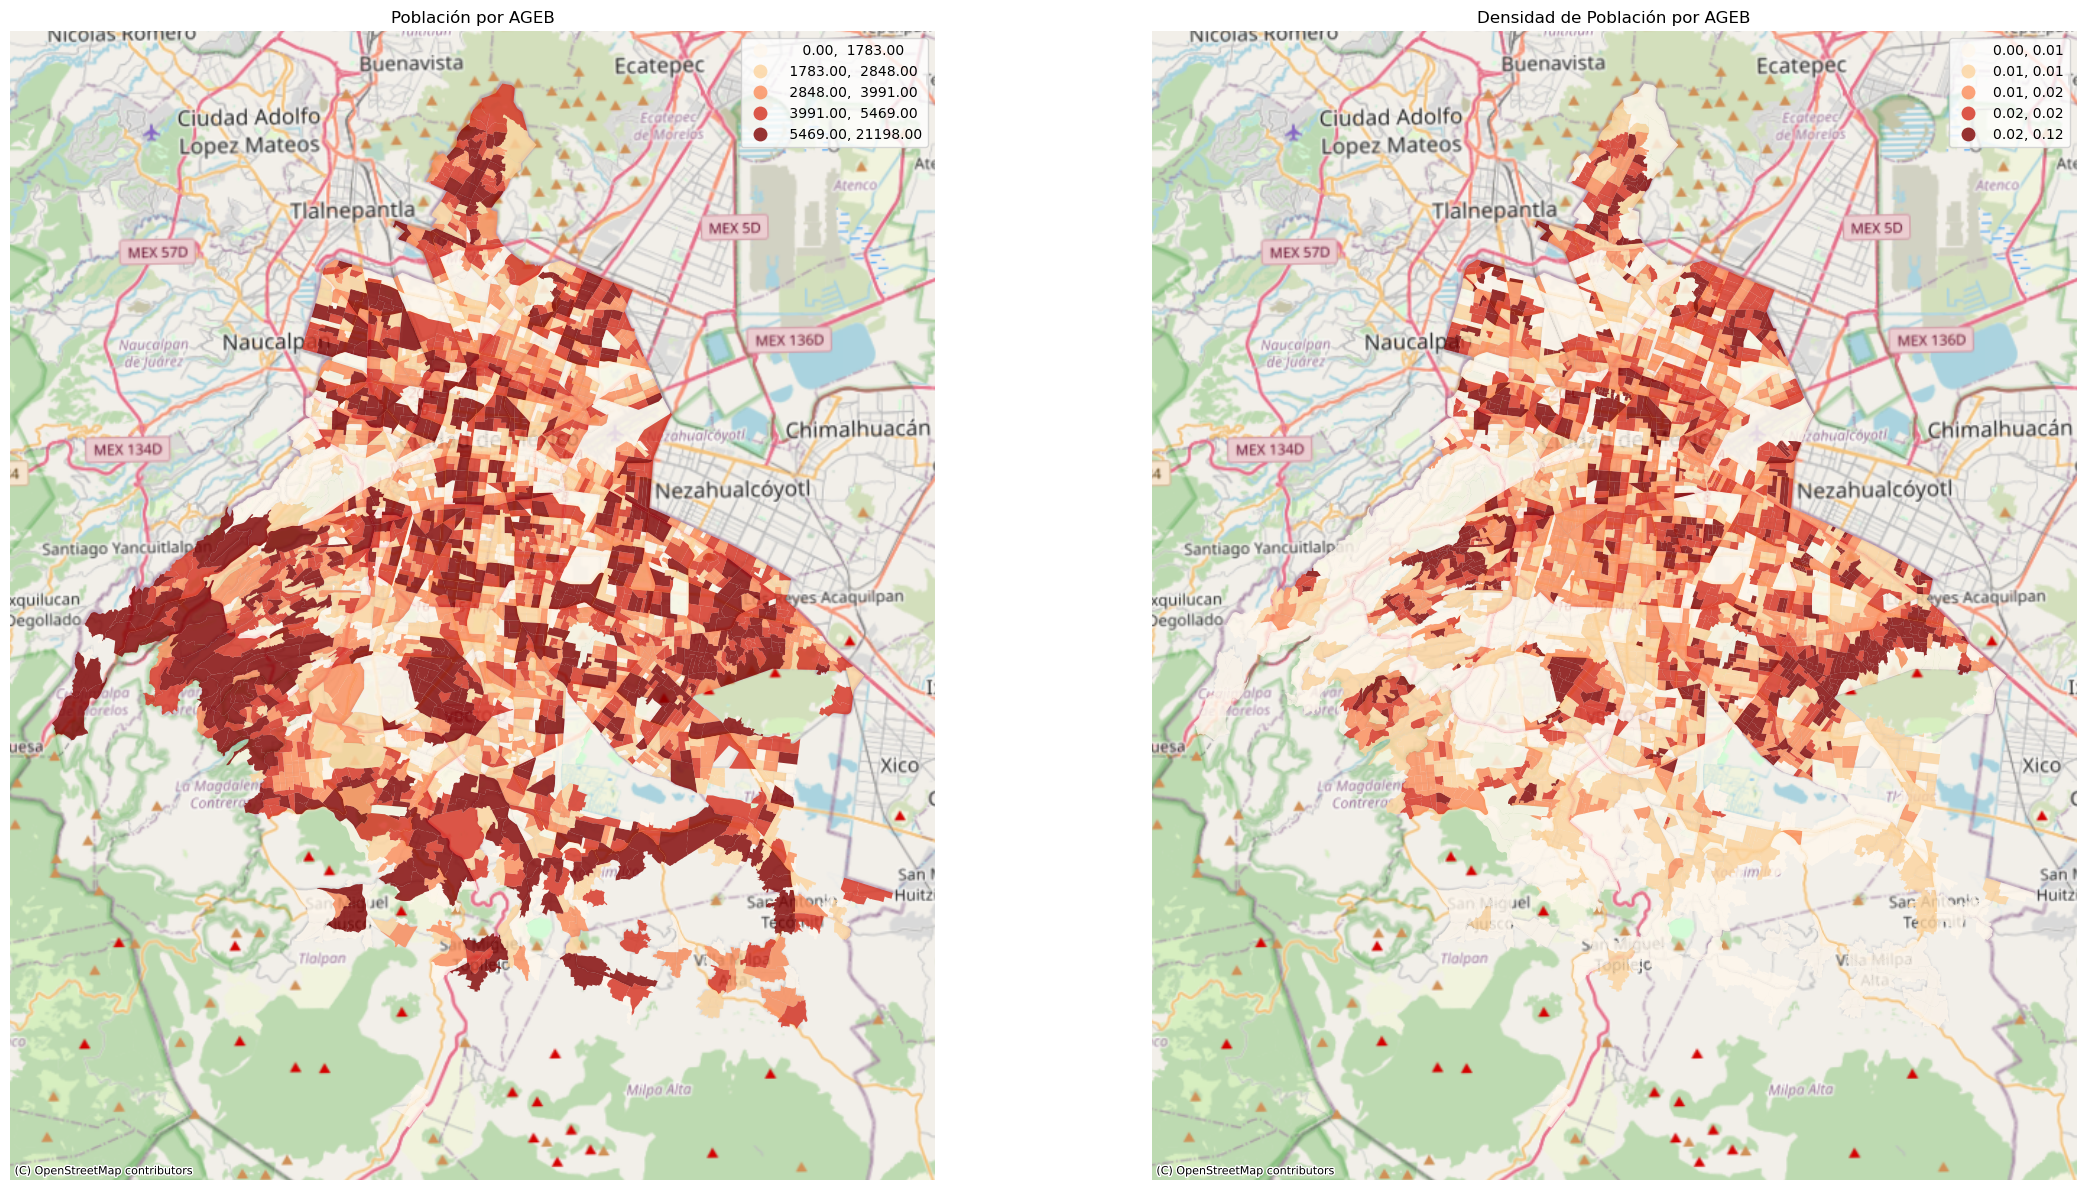

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,12))# Pedimos subfiguras con un renglón y dos columnas
agebs.plot('POBTOT', legend=True, cmap='OrRd', scheme='quantiles', ax=ax1, alpha=0.8)# Graficamos en el primer ax
ax1.set_title("Población por AGEB") # Este título está en el nivel ax, no en el figure
ax1.set_axis_off()
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
agebs.plot('densidad_pob', legend=True, cmap='OrRd', scheme='quantiles', ax=ax2, alpha=0.8)# Graficamos en el segndo ax
ax2.set_title("Densidad de Población por AGEB") # Este título está en el nivel ax, no en el figure
ax2.set_axis_off()
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
plt.tight_layout() # Para disminuir el espacio entre gráficas

Como pueden ver es relatívamente fácil poner dos gráficas, sólo hay que especificar cómo las queremos organizar y entender que `subplots` nos va a regresar un `array` de ejes. Para que quede aún más claro, vamos a hacer ahora cuatro mapas, comparando los porcentajes de poblaión para distintos grupos de edad. Primero vamos a calcular las variables que vamos a mapear

In [34]:
agebs['prop_0a2'] = agebs['P_0A2'] / agebs['POBTOT']
agebs['prop_12a14'] = agebs['P_12A14'] / agebs['POBTOT']
agebs['prop_18a24'] = agebs['P_18A24'] / agebs['POBTOT']
agebs['prop_60ymas'] = agebs['P_60YMAS'] / agebs['POBTOT']
agebs.head()

CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  \
0901000011716      09     010    0001     1716   
0901000012150      09     010    0001     2150   
0901000011133      09     010    0001     1133   
0901000011307      09     010    0001     1307   
0901000010281      09     010    0001     0281   

                                                        geometry ENTIDAD  \
0901000011716  POLYGON ((2787237.541 816989.461, 2787288.728 ...      09   
0901000012150  POLYGON ((2794154.458 823013.444, 2794155.774 ...      09   
0901000011133  POLYGON ((2795690.723 820050.788, 2795684.238 ...      09   
0901000011307  POLYGON ((2792584.475 815678.668, 2792624.325 ...      09   
0901000010281  POLYGON ((2788845.392 823526.074, 2788840.549 ...      09   

                        NOM_ENT  MUN         NOM_MUN   LOC  ... VPH_CVJ  \
0901000011716  Ciudad de México  010  Álvaro Obregón  0001  ...   210.0   
0901000012150  Ciudad de México  010  Álvaro Obregón  0001  ...   450.0   
0901000011133  Ciudad de México  010  Álvaro Obregón  0001  ...   212.0   
0901000011307  Ciudad de México  010  Álvaro Obregón  0001  ...   348.0   
0901000010281  Ciudad de México  010  Álvaro Obregón  0001  ...    30.0   

              VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  densidad_pob  \
0901000011716       45.0        82.0        601.0         9.0      0.026401   
0901000012150       21.0        24.0        261.0         NaN      0.020798   
0901000011133       19.0         NaN         23.0         0.0      0.003744   
0901000011307        NaN         0.0         18.0         0.0      0.002738   
0901000010281        0.0         0.0          0.0         0.0      0.001238   

               prop_0a2  prop_12a14  prop_18a24  prop_60ymas  
0901000011716  0.032803    0.054530    0.119710     0.131497  
0901000012150  0.022014    0.034656    0.094377     0.192241  
0901000011133  0.010894    0.033137    0.088970     0.261008  
0901000011307  0.018874    0.027111    0.120453     0.237131  
0901000010281  0.012658    0.042194    0.067511     0.189873  

[5 rows x 240 columns]

Ahora vamos a hacer un _layout_ con cuatro subplots en dos renglones y dos columnas

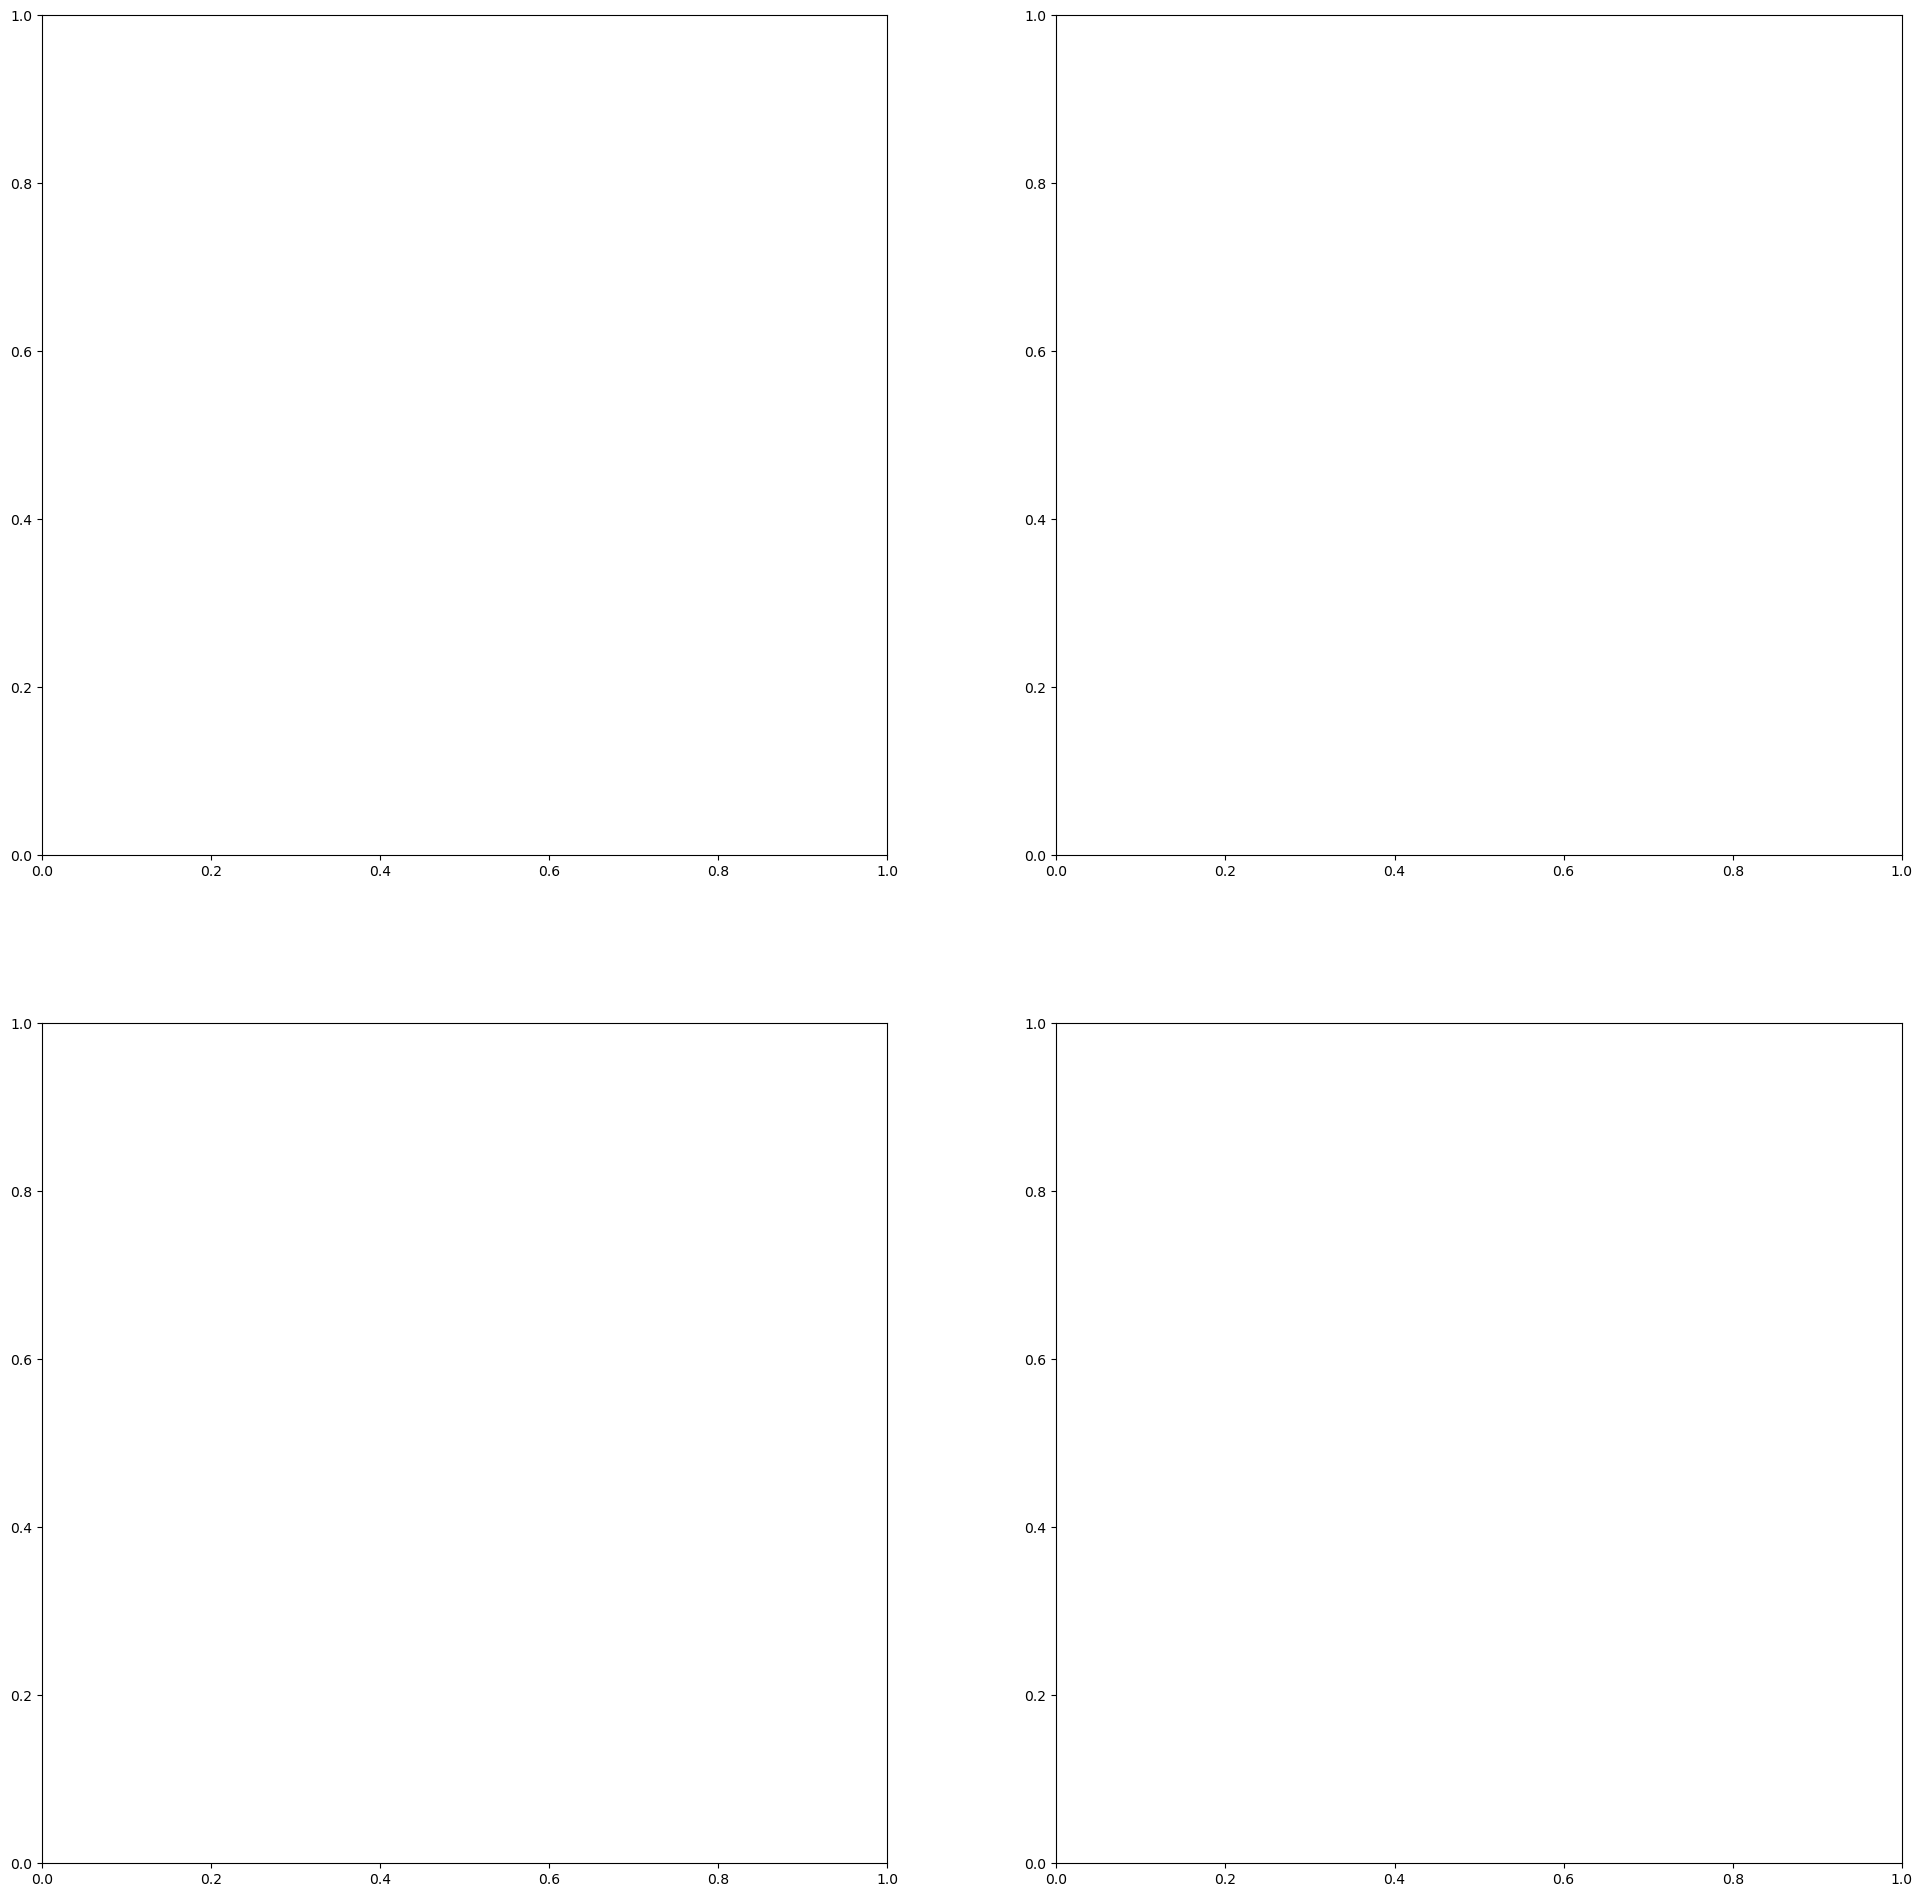

In [35]:
fig, axes = plt.subplots(2,2, figsize=(24,24))# Pedimos subfiguras con un renglón y dos columnas

Fíjense lo que tenemos ahora en el objeto `axes`

In [36]:
axes

array([[<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

Es un _array_ de 2x2 que tiene la misma forma de la figura. Para manejarlo más fácil, vamos a aplanar el _array_

In [37]:
axes.ravel()

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

Eso ya tiene una sola dimensión y lo podemos usar de la misma forma que antes

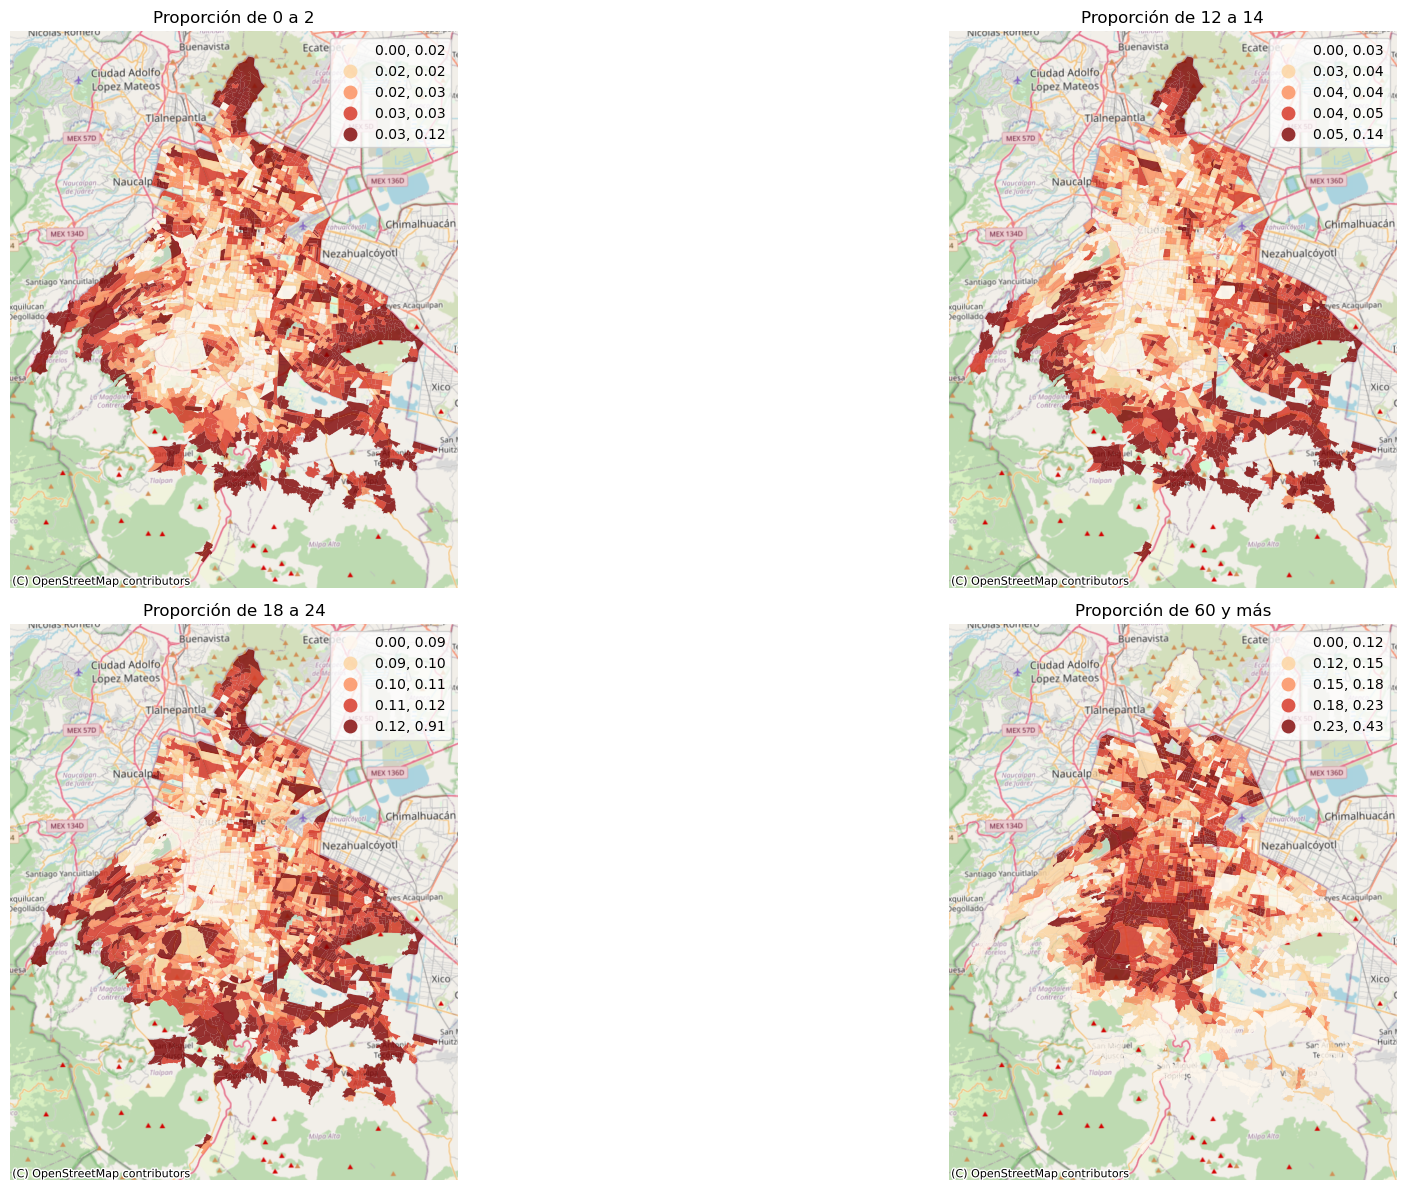

In [38]:
fig, axes = plt.subplots(2,2, figsize=(24,12))# Pedimos subfiguras con un renglón y dos columnas
axes = axes.ravel() # aplanamos el array
agebs.plot('prop_0a2', legend=True, cmap='OrRd', scheme='quantiles', ax=axes[0], alpha=0.8)# Graficamos en el primer ax
axes[0].set_title("Proporción de 0 a 2") # Este título está en el nivel ax, no en el figure
axes[0].set_axis_off()
ctx.add_basemap(axes[0], source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
agebs.plot('prop_12a14', legend=True, cmap='OrRd', scheme='quantiles', ax=axes[1], alpha=0.8)# Graficamos en el segndo ax
axes[1].set_title("Proporción de 12 a 14") # Este título está en el nivel ax, no en el figure
axes[1].set_axis_off()
ctx.add_basemap(axes[1], source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
agebs.plot('prop_18a24', legend=True, cmap='OrRd', scheme='quantiles', ax=axes[2], alpha=0.8)# Graficamos en el segndo ax
axes[2].set_title("Proporción de 18 a 24") # Este título está en el nivel ax, no en el figure
axes[2].set_axis_off()
ctx.add_basemap(axes[2], source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
agebs.plot('prop_60ymas', legend=True, cmap='OrRd', scheme='quantiles', ax=axes[3], alpha=0.8)# Graficamos en el segndo ax
axes[3].set_title("Proporción de 60 y más") # Este título está en el nivel ax, no en el figure
axes[3].set_axis_off()
ctx.add_basemap(axes[3], source=ctx.providers.OpenStreetMap.Mapnik, crs=agebs.crs.to_string())
plt.tight_layout() # Para disminuir el espacio entre gráficas
plt.show()